In [98]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

import sqlite3

import pandas as pd
import numpy as np
from pandas import date_range

In [99]:
#Format a dataframe after impoting from SQL
def format_df(df_in):
    df=df_in.copy(deep=True)
    df["datetime"] = pd.to_datetime(df["datetime"])
    df=df.set_index('datetime')
    df["date"] = pd.to_datetime(df["date"])
    return df

In [100]:
con = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('NDBC_historical_raw_data',), ('NDBC_historical_raw_data_St#{STATIONNUMBER}',), ('NDBC_historical_raw_data_St{STATIONNUMBER}',), ('NDBC_historical_raw_data_St46054',), ('NDBC_historical_cleaned_data',)]


In [101]:
#Query cleaned data from DB
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
df_cleaned = pd.read_sql_query("SELECT * FROM NDBC_historical_cleaned_data", conn, index_col=None)

In [102]:
df_engineered=format_df(df_cleaned)

In [103]:
df_engineered= df_engineered.resample("D").max()

In [104]:
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3910 entries, 2003-06-06 to 2014-02-17
Freq: D
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   WDIR    3910 non-null   float64       
 1   WSPD    3910 non-null   float64       
 2   GST     3910 non-null   float64       
 3   PRES    3910 non-null   float64       
 4   ATMP    3910 non-null   float64       
 5   WTMP    3910 non-null   float64       
 6   date    3910 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 244.4 KB


In [105]:
fourier_pairs=CalendarFourier(freq="A", order=3)


dp=DeterministicProcess(
    index=df_engineered.index,
    constant=True,
    order=1,
    additional_terms=[fourier_pairs],
    drop=True,
)

X=dp.in_sample()

In [106]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3910 entries, 2003-06-06 to 2014-02-17
Freq: D
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   const              3910 non-null   float64
 1   trend              3910 non-null   float64
 2   sin(1,freq=A-DEC)  3910 non-null   float64
 3   cos(1,freq=A-DEC)  3910 non-null   float64
 4   sin(2,freq=A-DEC)  3910 non-null   float64
 5   cos(2,freq=A-DEC)  3910 non-null   float64
 6   sin(3,freq=A-DEC)  3910 non-null   float64
 7   cos(3,freq=A-DEC)  3910 non-null   float64
dtypes: float64(8)
memory usage: 274.9 KB


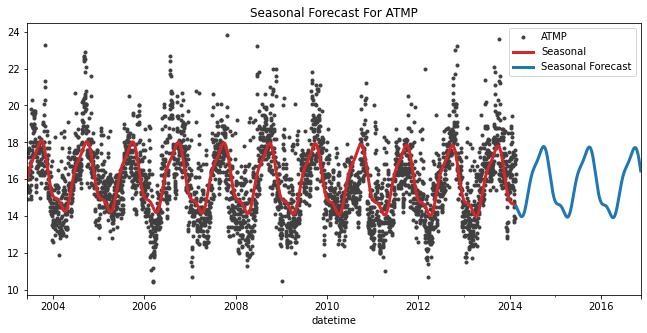

In [107]:
#Fourier seasonal features

y = df_engineered["ATMP"]

model = LinearRegression(fit_intercept=False)
results = model.fit(X, y)

#forecast_index = date_range(start="2014-02-17", freq="D", periods=1000)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=1000,)# forecast_index=forecast_index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title=f"Seasonal Forecast For {y.name}", figsize=(11, 5))
ax = y_pred.plot(ax=ax, label="Seasonal", linewidth=3, color='C3')
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", linewidth=3, color='C0')
leg=ax.legend()

In [108]:
df_engineered=df_engineered.join(X)

In [109]:
def make_lag_columns(df_in, num_lags, lag_column):

    df=df_in.copy(deep=True)

    for i in range(num_lags):
        lag=i+1
        new_lag_column=f'{lag_column}_lag_{lag}'
        df[new_lag_column]=df[lag_column].shift(lag)

        df.dropna(subset=[new_lag_column], inplace=True)

    return df

In [111]:
df_engineered=make_lag_columns(df_engineered, 8, 'ATMP')
df_engineered=make_lag_columns(df_engineered, 8, 'WTMP')
df_engineered=make_lag_columns(df_engineered, 2, 'WSPD')

In [ ]:
# Add seasonal indicators
df_engineered["Month"] = df_engineered.index.month

In [112]:
#Save data to local SQLite database
conn = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
df_engineered.to_sql(name=f'NDBC_historical_data_for_training',con=conn,schema='NDBC_model_building_database.db',if_exists='replace') 


In [113]:
con = sqlite3.connect(r"C:\Users\dakot\Desktop\DataScience\projects\weather_prediction\NDBC_model_building_database.db")
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('NDBC_historical_raw_data',), ('NDBC_historical_raw_data_St#{STATIONNUMBER}',), ('NDBC_historical_raw_data_St{STATIONNUMBER}',), ('NDBC_historical_raw_data_St46054',), ('NDBC_historical_cleaned_data',), ('NDBC_historical_data_for_training',)]
